# Oil Spill Detection - Exploratory Data Analysis

**Objective**: Analyze raw dataset characteristics to inform preprocessing decisions

**Key Tasks**:
- Analyze image dimensions and formats
- Study pixel value distributions
- Examine mask characteristics
- Identify dataset imbalances

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

#results
os.makedirs('../results/eda', exist_ok=True)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Dataset Structure Analysis

 Dataset Statistics:


images  masks  missing_masks  images_pct  masks_pct
train     811    811              0       63.96      63.96
val       203    203              0       16.01      16.01
test      254    254              0       20.03      20.03


Total Images: 1268
Total Masks: 1268


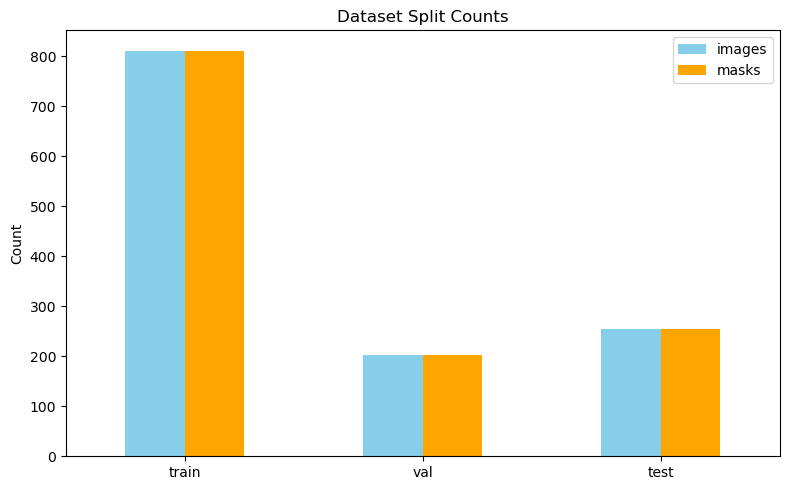

In [20]:
dataset_path = '../dataset'
splits = ['train', 'val', 'test']
image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.bmp')  # Supported image formats
mask_extension = '.png'  # Masks assumed PNG

results_dir = '../results/eda'
os.makedirs(results_dir, exist_ok=True)

dataset_stats = {}

for split in splits:
    images_path = os.path.join(dataset_path, split, 'images')
    masks_path = os.path.join(dataset_path, split, 'masks')
    
    if os.path.exists(images_path) and os.path.exists(masks_path):
        
        images = [f for f in os.listdir(images_path) if f.lower().endswith(image_extensions)]
        masks  = [f for f in os.listdir(masks_path) if f.lower().endswith(mask_extension)]
        
        image_bases = [os.path.splitext(f)[0] for f in images]
        mask_bases  = [os.path.splitext(f)[0] for f in masks]
        
        missing_masks = [f + os.path.splitext(images[0])[1] for f in image_bases if f not in mask_bases]
        if missing_masks:
            print(f"⚠️ Missing masks in {split}: {len(missing_masks)}")
        
        dataset_stats[split] = {
            'images': len(images),
            'masks': len(masks),
            'missing_masks': len(missing_masks)
        }
    else:
        dataset_stats[split] = {'images': 0, 'masks': 0, 'missing_masks': 0}

stats_df = pd.DataFrame(dataset_stats).T

total_images = stats_df['images'].sum()
total_masks  = stats_df['masks'].sum()
stats_df['images_pct'] = (stats_df['images'] / total_images * 100).round(2)
stats_df['masks_pct']  = (stats_df['masks'] / total_masks * 100).round(2)

print(" Dataset Statistics:")
display(stats_df)

print(f"\nTotal Images: {total_images}")
print(f"Total Masks: {total_masks}")

stats_df.to_csv(os.path.join(results_dir, 'dataset_statistics.csv'), index=True)

stats_df[['images', 'masks']].plot(kind='bar', figsize=(8,5), title='Dataset Split Counts', color=['skyblue','orange'])
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 2. Image Dimensions Analysis


Image Dimension Statistics for 'train' split:
Width - Min: 768, Max: 5184, Mean: 1873.0, Median: 1920.0, Std: 994.4
Height - Min: 432, Max: 2920, Mean: 1053.8, Median: 1080.0, Std: 560.2
File Size - Min: 114.5KB, Max: 7581.0KB, Mean: 1029.4KB, Median: 611.6KB

Unique dimensions found: 3
  1920x1080: 142 images (71.0%)
  768x432: 45 images (22.5%)
  5184x2920: 13 images (6.5%)


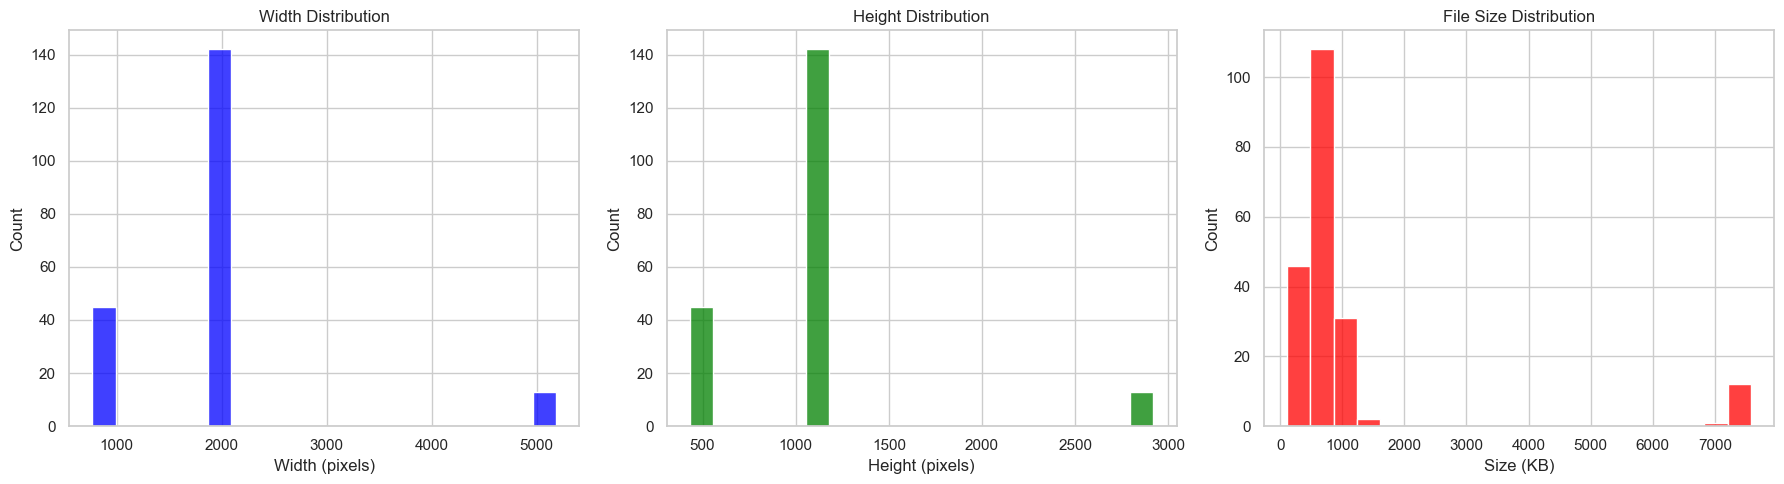

In [23]:
def analyze_image_dimensions(split='train', max_samples=100):
    images_path = os.path.join(dataset_path, split, 'images')
    image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.bmp')
    
    if not os.path.exists(images_path):
        print(f"Path {images_path} does not exist")
        return None, None
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(image_extensions)]
    
    if not image_files:
        print(f"No images found in {images_path}")
        return None, None
    
    sample_files = image_files[:min(max_samples, len(image_files))]
    
    dimensions = []
    file_sizes = []
    
    for img_file in sample_files:
        try:
            img_path = os.path.join(images_path, img_file)
            with Image.open(img_path) as img:
                dimensions.append(img.size)  # (width, height)
                file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    widths = [d[0] for d in dimensions]
    heights = [d[1] for d in dimensions]
    
    print(f"\nImage Dimension Statistics for '{split}' split:")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}, Median: {np.median(widths)}, Std: {np.std(widths):.1f}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}, Median: {np.median(heights)}, Std: {np.std(heights):.1f}")
    print(f"File Size - Min: {min(file_sizes):.1f}KB, Max: {max(file_sizes):.1f}KB, Mean: {np.mean(file_sizes):.1f}KB, Median: {np.median(file_sizes):.1f}KB")
    
    unique_dims = sorted(list(set(dimensions)), key=lambda x: dimensions.count(x), reverse=True)
    print(f"\nUnique dimensions found: {len(unique_dims)}")
    if len(unique_dims) <= 20:
        for dim in unique_dims:
            count = dimensions.count(dim)
            print(f"  {dim[0]}x{dim[1]}: {count} images ({count/len(dimensions)*100:.1f}%)")
    
    import seaborn as sns
    sns.set(style="whitegrid")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.histplot(widths, bins=20, kde=False, color='blue', ax=axes[0])
    axes[0].set_title('Width Distribution')
    axes[0].set_xlabel('Width (pixels)')
    
    sns.histplot(heights, bins=20, kde=False, color='green', ax=axes[1])
    axes[1].set_title('Height Distribution')
    axes[1].set_xlabel('Height (pixels)')
    
    sns.histplot(file_sizes, bins=20, kde=False, color='red', ax=axes[2])
    axes[2].set_title('File Size Distribution')
    axes[2].set_xlabel('Size (KB)')
    
    plt.tight_layout()
    os.makedirs('../results/eda', exist_ok=True)
    plt.savefig('../results/eda/image_dimensions_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return dimensions, file_sizes
dimensions, file_sizes = analyze_image_dimensions('train', max_samples=200)


## 3. Pixel Value Distribution Analysis

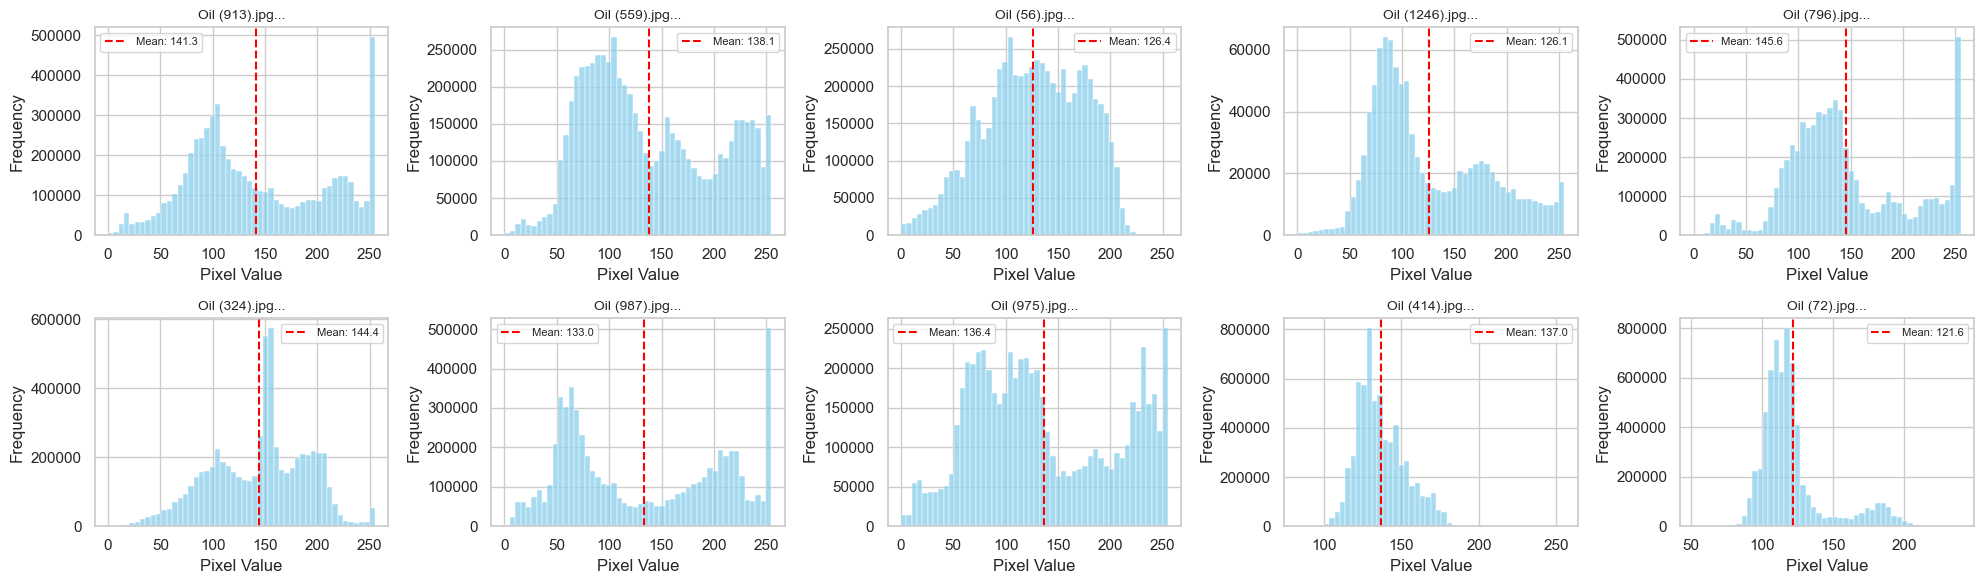


Overall Pixel Statistics:
Mean: 135.81
Std: 55.14
Min: 0
Max: 255
Median: 128.00
5th Percentile: 53.00
95th Percentile: 241.00


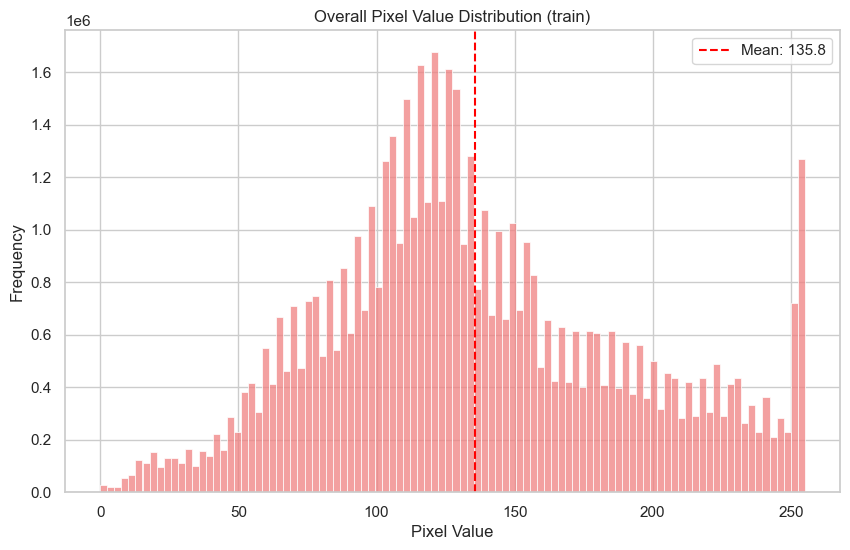

In [ ]:
def analyze_pixel_distributions(split='train', num_samples=10, normalize=False):
    import seaborn as sns
    sns.set(style="whitegrid")
    
    images_path = os.path.join(dataset_path, split, 'images')
    image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.bmp')
    
    if not os.path.exists(images_path):
        print(f"Path {images_path} does not exist")
        return
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(image_extensions)]
    if not image_files:
        print(f"No images found in {images_path}")
        return
    
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    n_cols = 5
    n_rows = int(np.ceil(len(sample_files) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten()
    
    all_pixels = []
    
    for i, img_file in enumerate(sample_files):
        try:
            img_path = os.path.join(images_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            pixels = img_rgb.flatten()
            if normalize:
                pixels = pixels / 255.0
            all_pixels.extend(pixels)
            
            sns.histplot(pixels, bins=50, ax=axes[i], color='skyblue', kde=False)
            axes[i].set_title(f"{img_file[:20]}...", fontsize=10)
            axes[i].set_xlabel('Pixel Value')
            axes[i].set_ylabel('Frequency')
            axes[i].axvline(np.mean(pixels), color='red', linestyle='--', label=f'Mean: {np.mean(pixels):.1f}')
            axes[i].legend(fontsize=8)
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    os.makedirs('../results/eda', exist_ok=True)
    plt.savefig('../results/eda/pixel_distributions_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    if all_pixels:
        all_pixels = np.array(all_pixels)
        print("\nOverall Pixel Statistics:")
        print(f"Mean: {np.mean(all_pixels):.2f}")
        print(f"Std: {np.std(all_pixels):.2f}")
        print(f"Min: {np.min(all_pixels)}")
        print(f"Max: {np.max(all_pixels)}")
        print(f"Median: {np.median(all_pixels):.2f}")
        print(f"5th Percentile: {np.percentile(all_pixels,5):.2f}")
        print(f"95th Percentile: {np.percentile(all_pixels,95):.2f}")
        
        plt.figure(figsize=(10,6))
        sns.histplot(all_pixels, bins=100, color='lightcoral', kde=False)
        plt.title(f'Overall Pixel Value Distribution ({split})')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.axvline(np.mean(all_pixels), color='red', linestyle='--', label=f'Mean: {np.mean(all_pixels):.1f}')
        plt.legend()
        plt.savefig('../results/eda/overall_pixel_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

analyze_pixel_distributions('train', num_samples=10, normalize=False)


## 4. Mask Analysis

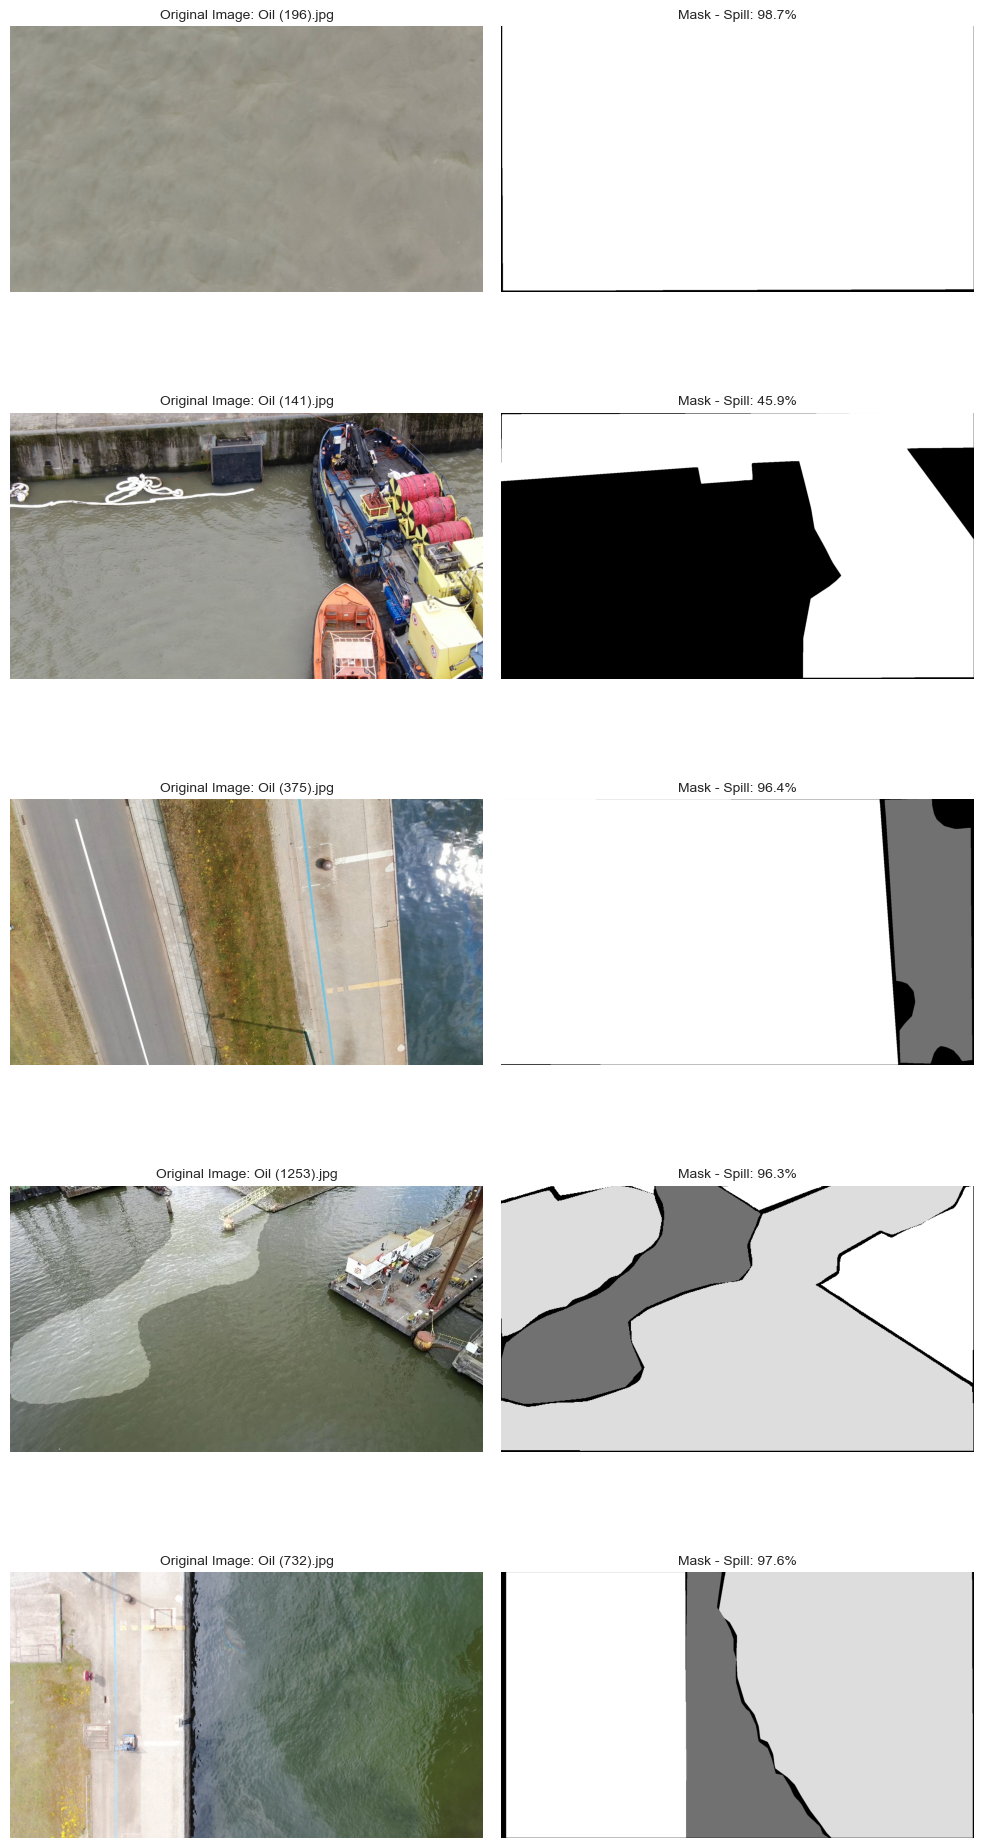


Mask Analysis Results:
Average spill coverage: 86.96%
Spill coverage range: 45.91% - 98.70%
Unique pixel values in masks: [0, 90, 174, 201]


In [29]:
def analyze_masks_with_images(split='train', num_samples=10):
    images_path = os.path.join(dataset_path, split, 'images')
    masks_path  = os.path.join(dataset_path, split, 'masks')
    
    if not os.path.exists(images_path) or not os.path.exists(masks_path):
        print(f"Path {images_path} or {masks_path} does not exist")
        return
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    mask_files  = [f for f in os.listdir(masks_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    spill_percentages = []
    unique_values_list = []
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    
    if num_samples == 1:
        axes = np.array([axes])
    
    for i, img_file in enumerate(sample_files):
        try:
            img_path = os.path.join(images_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            base_name = os.path.splitext(img_file)[0]
            mask_candidates = [f for f in mask_files if os.path.splitext(f)[0]==base_name]
            
            if not mask_candidates:
                print(f"No mask found for {img_file}")
                continue
            
            mask_path = os.path.join(masks_path, mask_candidates[0])
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            spill_pixels = np.sum(mask > 0)
            total_pixels = mask.size
            spill_percentage = (spill_pixels / total_pixels) * 100
            spill_percentages.append(spill_percentage)
            
            unique_values_list.append(np.unique(mask))
            
            axes[i,0].imshow(img)
            axes[i,0].set_title(f"Original Image: {img_file}", fontsize=10)
            axes[i,0].axis('off')
            
            axes[i,1].imshow(mask, cmap='gray')
            axes[i,1].set_title(f"Mask - Spill: {spill_percentage:.1f}%", fontsize=10)
            axes[i,1].axis('off')
            
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    plt.tight_layout()
    os.makedirs('../results/eda', exist_ok=True)
    plt.savefig('../results/eda/masks_with_images.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nMask Analysis Results:")
    print(f"Average spill coverage: {np.mean(spill_percentages):.2f}%")
    print(f"Spill coverage range: {np.min(spill_percentages):.2f}% - {np.max(spill_percentages):.2f}%")
    
    all_unique = set()
    for vals in unique_values_list:
        all_unique.update(vals)
    print(f"Unique pixel values in masks: {sorted(all_unique)}")
    
    return spill_percentages, unique_values_list

spill_percentages, unique_values = analyze_masks_with_images('train', num_samples=5)


## 5. Dataset Balance Analysis

Analyzing 811 masks for balance in train set...


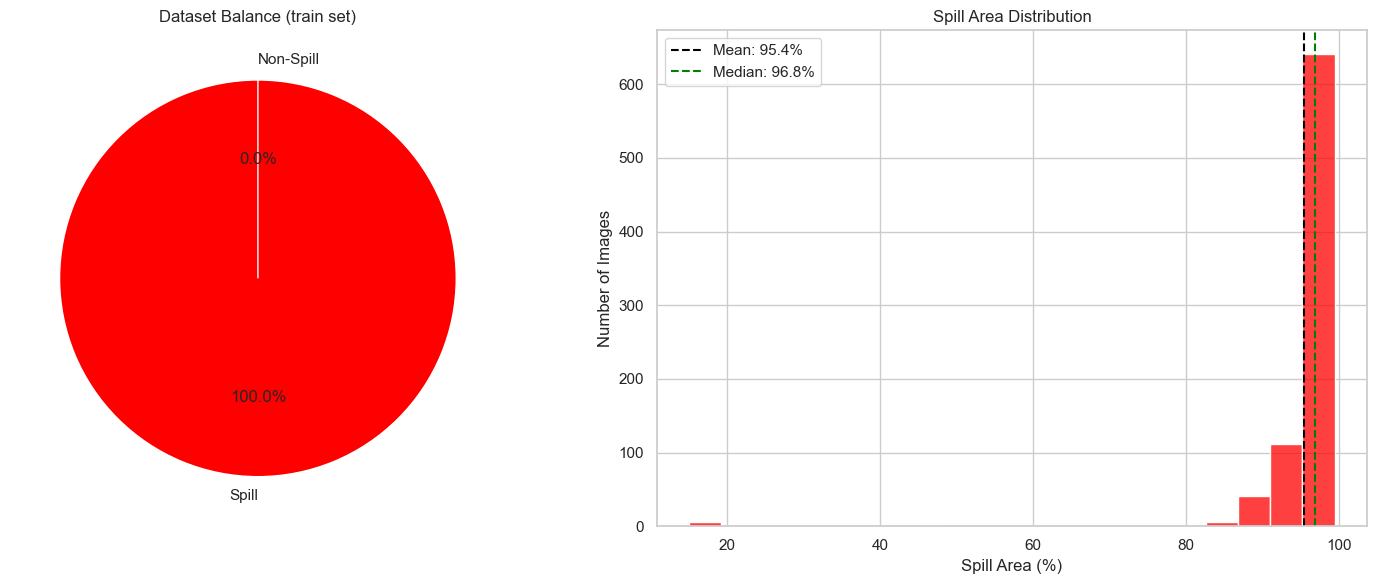

Analyzing 203 masks for balance in val set...


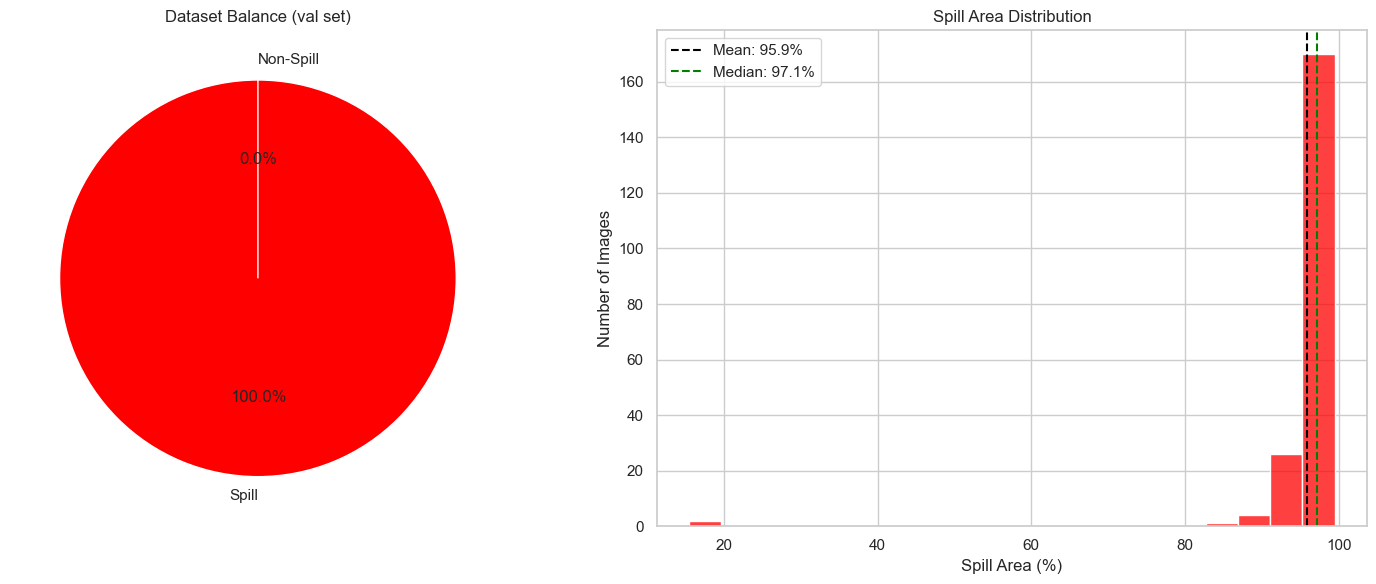

Analyzing 254 masks for balance in test set...


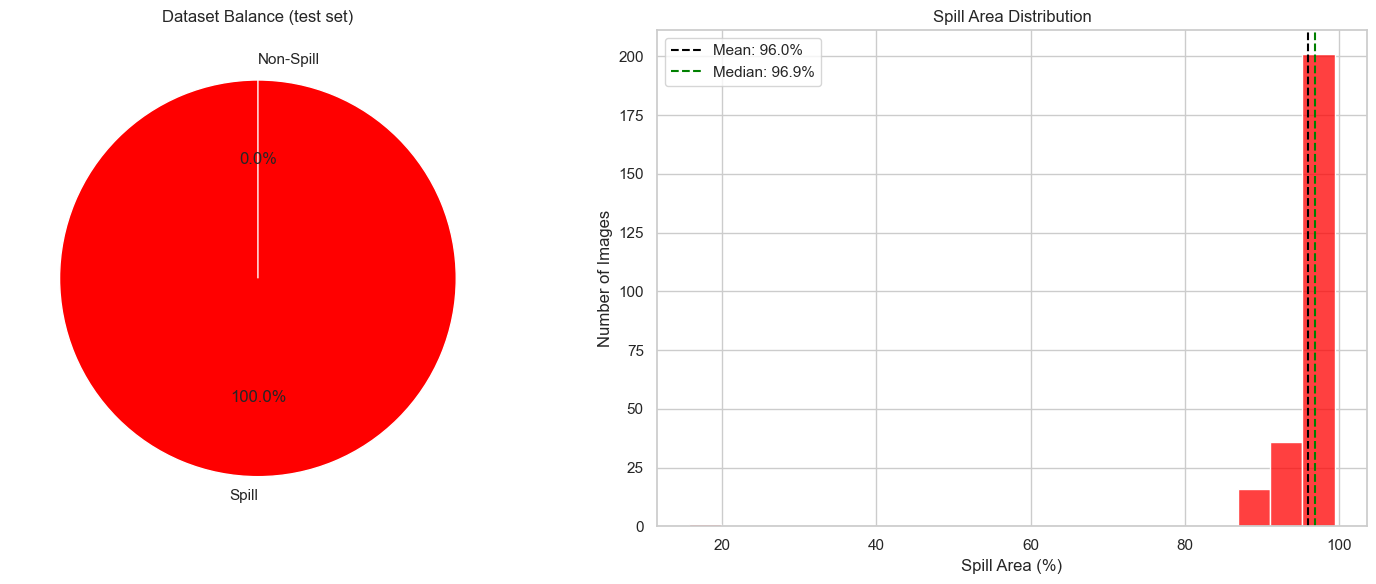


 Balance analysis saved to ../results/eda/dataset_balance_analysis.csv


In [30]:
def analyze_dataset_balance(split='train'):
    sns.set(style="whitegrid")
    
    masks_path = os.path.join(dataset_path, split, 'masks')
    mask_extension = '.png'
    
    if not os.path.exists(masks_path):
        print(f"Path {masks_path} does not exist")
        return None
    
    mask_files = [f for f in os.listdir(masks_path) if f.lower().endswith(mask_extension)]
    if not mask_files:
        print(f"No masks found in {masks_path}")
        return None
    
    spill_count = 0
    non_spill_count = 0
    spill_areas = []
    
    print(f"Analyzing {len(mask_files)} masks for balance in {split} set...")
    
    for mask_file in mask_files:
        try:
            mask_path = os.path.join(masks_path, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            
            spill_pixels = np.sum(mask > 0)
            if spill_pixels > 0:
                spill_count += 1
                spill_areas.append((spill_pixels / mask.size) * 100)
            else:
                non_spill_count += 1
        except Exception as e:
            print(f"Error processing {mask_file}: {e}")
    
    total_images = spill_count + non_spill_count
    avg_spill = np.mean(spill_areas) if spill_areas else 0
    median_spill = np.median(spill_areas) if spill_areas else 0
    
    balance_df = pd.DataFrame({
        'Total Images': [total_images],
        'Spill Images': [spill_count],
        'Non-Spill Images': [non_spill_count],
        'Spill %': [spill_count/total_images*100 if total_images>0 else 0],
        'Avg Spill Area %': [avg_spill],
        'Median Spill Area %': [median_spill]
    }, index=[split])
    
    display(balance_df.style.background_gradient(cmap="Reds"))
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].pie([spill_count, non_spill_count], labels=['Spill','Non-Spill'], 
                colors=['red','skyblue'], autopct='%1.1f%%', startangle=90)
    axes[0].set_title(f'Dataset Balance ({split} set)')
    
    if spill_areas:
        sns.histplot(spill_areas, bins=20, color='red', ax=axes[1], kde=False)
        axes[1].set_title('Spill Area Distribution')
        axes[1].set_xlabel('Spill Area (%)')
        axes[1].set_ylabel('Number of Images')
        axes[1].axvline(avg_spill, color='black', linestyle='--', label=f'Mean: {avg_spill:.1f}%')
        axes[1].axvline(median_spill, color='green', linestyle='--', label=f'Median: {median_spill:.1f}%')
        axes[1].legend()
    
    plt.tight_layout()
    os.makedirs('../results/eda', exist_ok=True)
    plt.savefig(f'../results/eda/dataset_balance_{split}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'split': split,
        'total_images': total_images,
        'spill_images': spill_count,
        'non_spill_images': non_spill_count,
        'spill_percentage': spill_count/total_images*100 if total_images>0 else 0,
        'avg_spill_area': avg_spill,
        'median_spill_area': median_spill
    }

balance_results = {}
for split in ['train','val','test']:
    result = analyze_dataset_balance(split)
    if result:
        balance_results[split] = result

if balance_results:
    combined_df = pd.DataFrame(balance_results).T
    display(combined_df.style.background_gradient(cmap="Reds"))
    combined_df.to_csv('../results/eda/dataset_balance_analysis.csv', index=True)
    print("\n Balance analysis saved to ../results/eda/dataset_balance_analysis.csv")


## 6. Sample Visualization

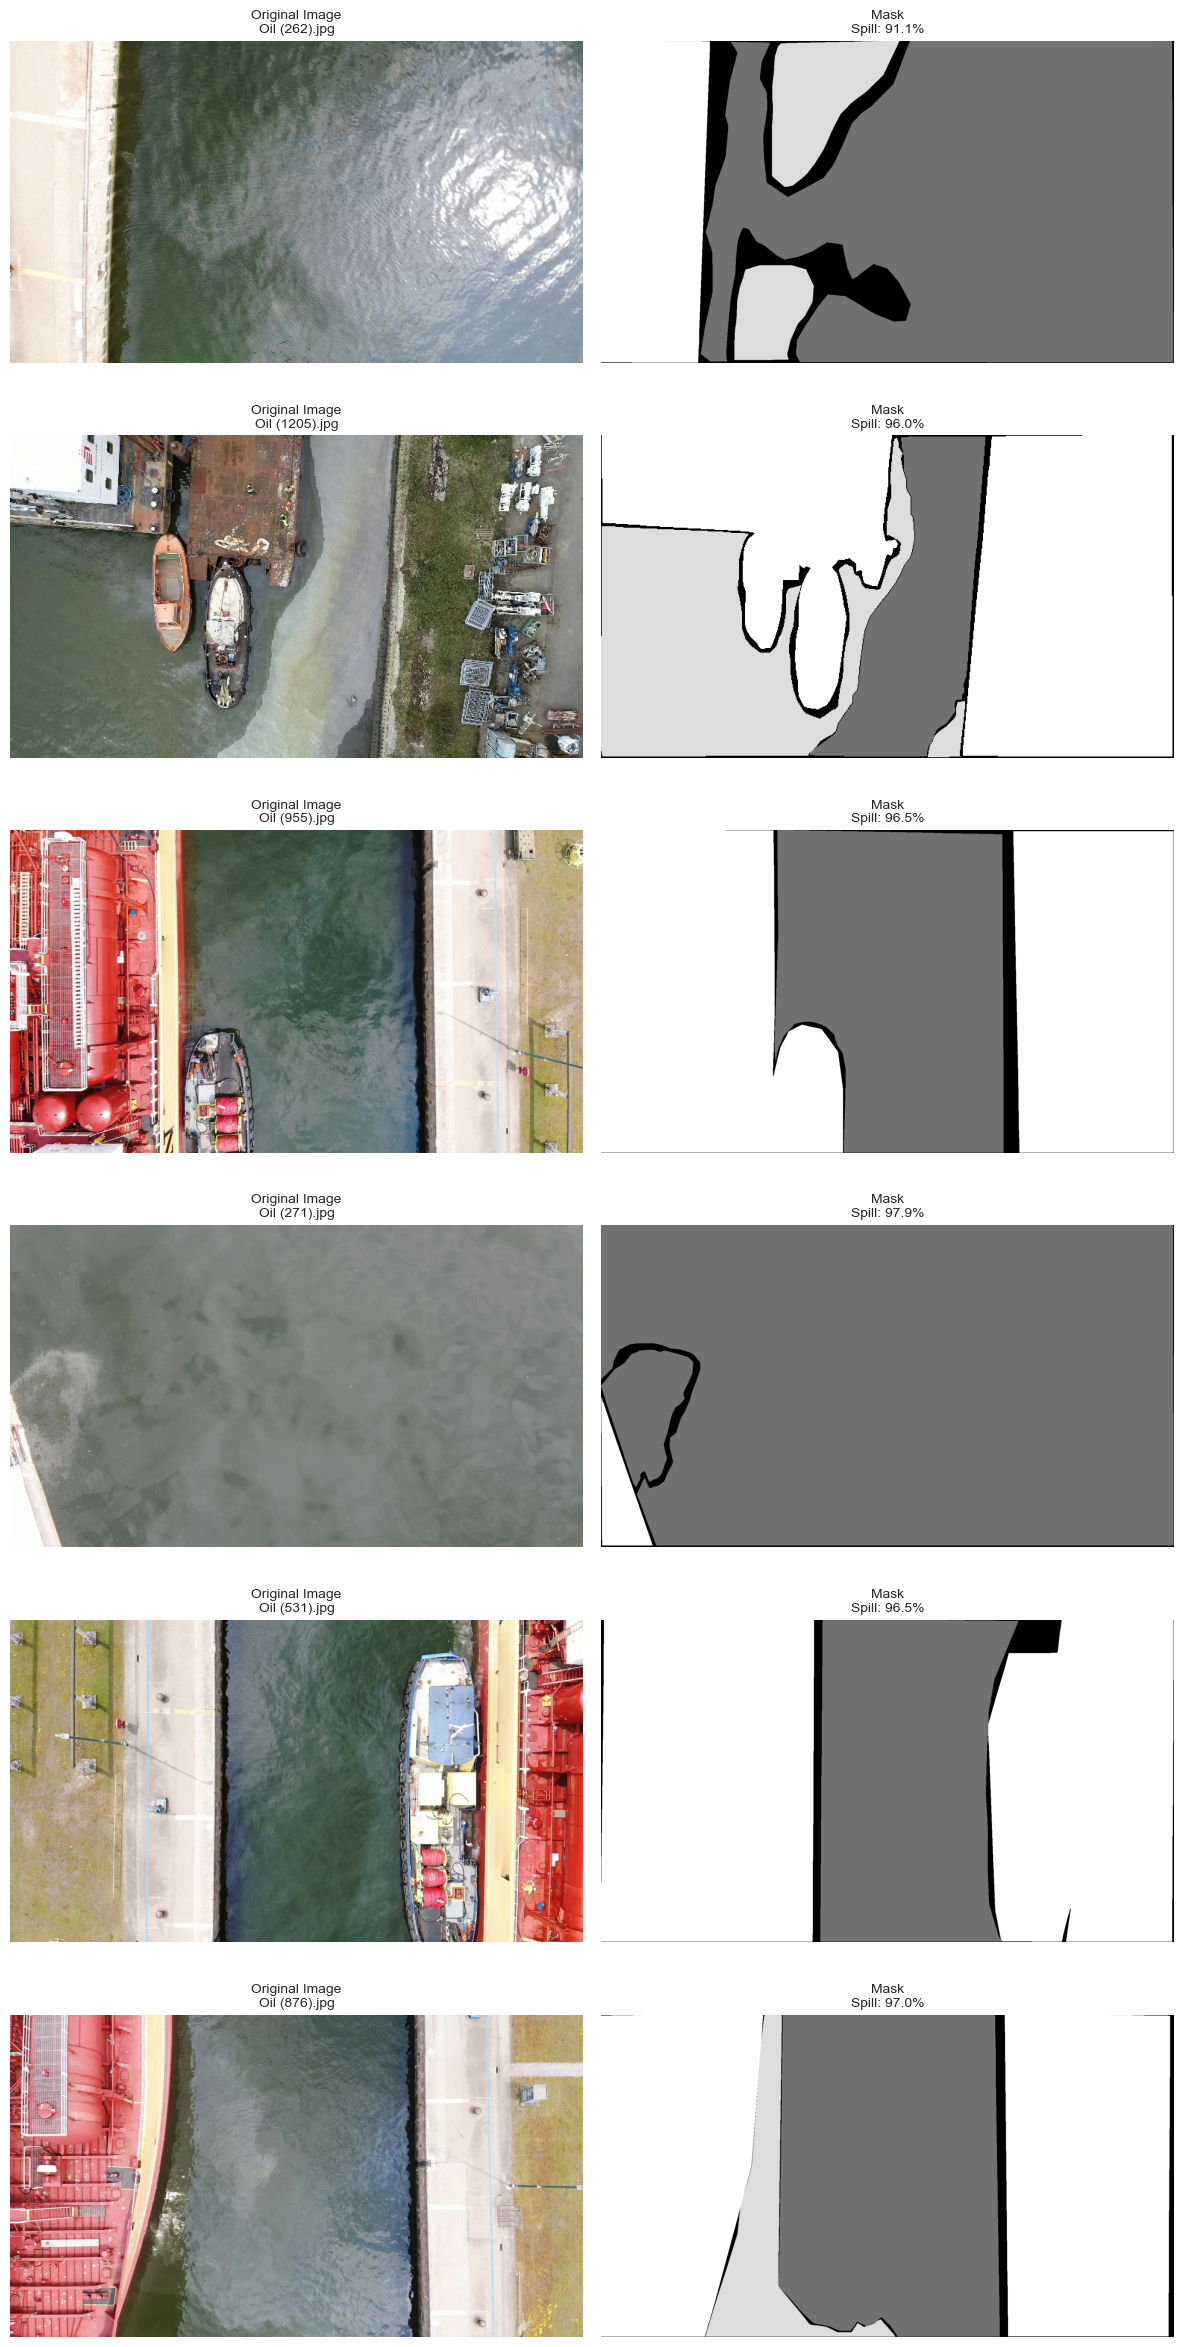

In [41]:
def visualize_samples(split='train', num_samples=6):
    images_path = os.path.join(dataset_path, split, 'images')
    masks_path = os.path.join(dataset_path, split, 'masks')
    
    if not (os.path.exists(images_path) and os.path.exists(masks_path)):
        print(f"Required paths do not exist")
        return
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No images found")
        return
    
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, img_file in enumerate(sample_files):
        try:
            img_path = os.path.join(images_path, img_file)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask_file = os.path.splitext(img_file)[0] + '.png'
            mask_path = os.path.join(masks_path, mask_file)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                spill_pixels = np.sum(mask > 0)
                spill_percentage = (spill_pixels / mask.size) * 100
                
                axes[i, 0].imshow(img_rgb)
                axes[i, 0].set_title(f'Original Image\n{img_file}', fontsize=10)
                axes[i, 0].axis('off')
                
                axes[i, 1].imshow(mask, cmap='gray')
                axes[i, 1].set_title(f'Mask\nSpill: {spill_percentage:.1f}%', fontsize=10)
                axes[i, 1].axis('off')
            else:
                print(f"Mask not found for {img_file}")
                
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    plt.tight_layout()
    plt.savefig('../results/eda/sample_images_masks.png', dpi=300, bbox_inches='tight')
    plt.show()
visualize_samples('train', 6)